# Learn to build, evaluate, and select classification models
# Predicting Customer Response
## A direct marketing firm mails catalogs to its customer base of about 5 million households. Customers respond either by ordering items from the catalog, or do not respond. The firm distinguishes itself by mailing expensive catalogs, and – while the response rates to the firm's mailers are higher than the industry average (30% vs 22%) – they incur considerable printing and mailing costs. They are trying to improve their performance by identifying and targeting profitable customers, i.e., customers who are likely to respond (and order items that would justify the printing and mailing costs). They are particularly interested in lapsing customers (customers who made their last purchase 13 to 24 months ago).
## A preliminary study shows that customers seem to make their buying decision in two phases – they decide whether or not to respond first and, if they decide to respond, make a follow-up decision on what to order. dmtrain.csv contains information about 2,000 customers from the last mailing campaign. Everyone included has made at least one purchase from the firm in the past.

In [1]:
# import libraries

import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

## Question 1: Read in the data and review the non-binary variables to see if any are skewed and need to be transformed. If so, transform them and drop the non-transformed versions of the variables. Make sure that you do not include the customer identifier id in your calculations. Explain what you found, what transformations you applied, and why.

In [2]:
# Reading the dataset

train = pd.read_csv('dmtrain.csv')
train

,id,n24,rev24,revlast,elpsdm,ordfreq,ordcat,response
0,1,2,30.0,20.0,24,1,6,1
1,2,25,207.0,20.0,24,1,6,0
2,3,5,52.0,15.0,24,1,6,0
3,4,11,105.0,15.0,24,1,6,0
4,5,2,32.0,17.0,24,1,6,0
...,...,...,...,...,...,...,...,...
1995,1996,12,105.0,20.0,1,2,6,0
1996,1997,36,786.0,5.0,1,2,6,0
1997,1998,7,415.0,100.0,1,1,7,0
1998,1999,5,77.0,25.0,1,1,7,0


In [3]:
# checking for the missing values

train.isnull().any() # no missing values

id          False
n24         False
rev24       False
revlast     False
elpsdm      False
ordfreq     False
ordcat      False
response    False
dtype: bool

(array([196.,   0.,   0., 515.,   0.,   0., 928.,   0.,   0., 361.]),
 array([4. , 4.3, 4.6, 4.9, 5.2, 5.5, 5.8, 6.1, 6.4, 6.7, 7. ]),
 <BarContainer object of 10 artists>)

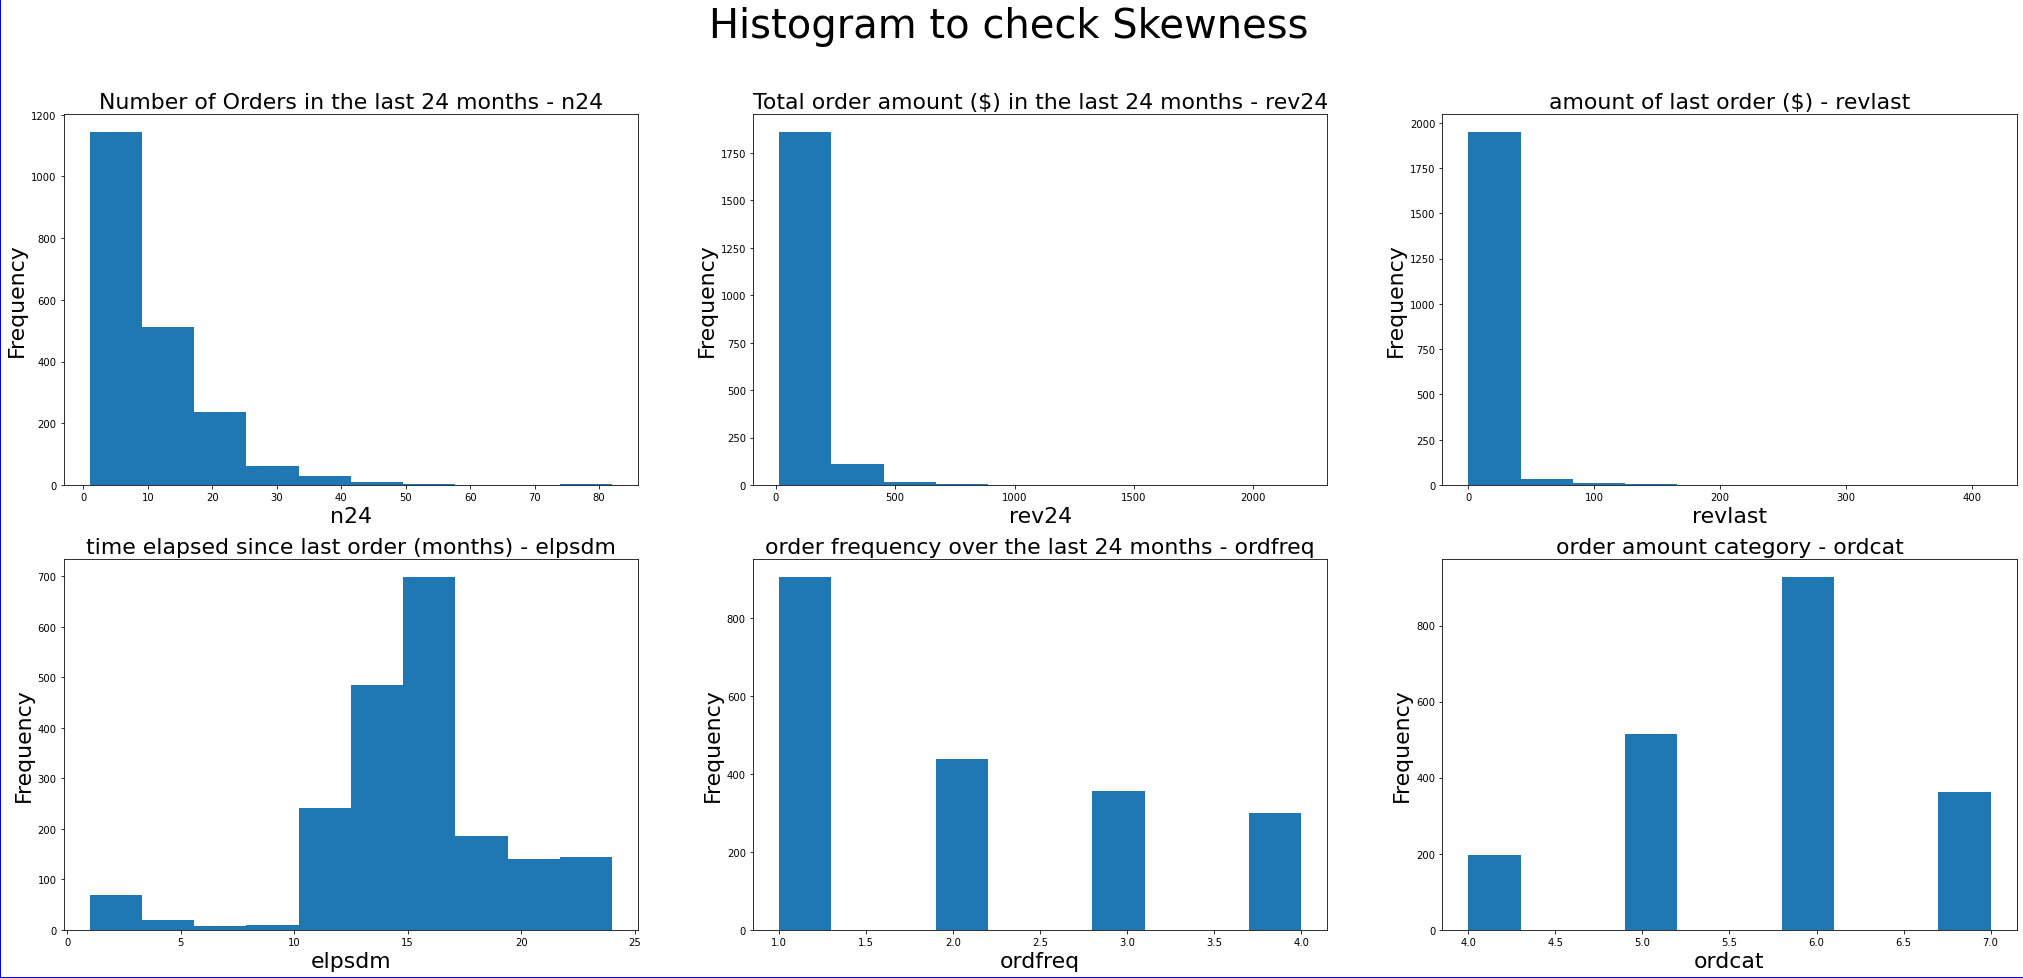

In [4]:
# plot histogram to check skewness

fig, plots = plt.subplots(2,3,figsize=(35,15))

fig.suptitle("Histogram to check Skewness", fontsize = 40)
fig.patch.set_edgecolor('blue')
fig.patch.set_linewidth(2) 

plots[0,0].set_title("Number of Orders in the last 24 months - n24", fontsize = 22)
plots[0,0].set_xlabel("n24", fontsize = 22)
plots[0,0].set_ylabel("Frequency", fontsize = 22)
plots[0,0].hist(train['n24'])

plots[0,1].set_title("Total order amount ($) in the last 24 months - rev24", fontsize = 22)
plots[0,1].set_xlabel("rev24", fontsize = 22)
plots[0,1].set_ylabel("Frequency", fontsize = 22)
plots[0,1].hist(train['rev24'])

plots[0,2].set_title("amount of last order ($) - revlast", fontsize = 22)
plots[0,2].set_xlabel("revlast", fontsize = 22)
plots[0,2].set_ylabel("Frequency", fontsize = 22)
plots[0,2].hist(train['revlast'])

plots[1,0].set_title("time elapsed since last order (months) - elpsdm", fontsize = 22)
plots[1,0].set_xlabel("elpsdm", fontsize = 22)
plots[1,0].set_ylabel("Frequency", fontsize = 22)
plots[1,0].hist(train['elpsdm'])

plots[1,1].set_title("order frequency over the last 24 months - ordfreq", fontsize = 22)
plots[1,1].set_xlabel("ordfreq", fontsize = 22)
plots[1,1].set_ylabel("Frequency", fontsize = 22)
plots[1,1].hist(train['ordfreq'])

plots[1,2].set_title("order amount category - ordcat", fontsize = 22)
plots[1,2].set_xlabel("ordcat", fontsize = 22)
plots[1,2].set_ylabel("Frequency", fontsize = 22)
plots[1,2].hist(train['ordcat'])

In [5]:
# skewness check

from scipy.stats import skew
print('n24: ', skew(train['n24'])) # right-skewed
print('rev24: ', skew(train['rev24'])) # heavily right-skewed
print('revlast: ', skew(train['revlast'])) # heavily right-skewed
print('elpsdm: ', skew(train['elpsdm'])) # slightly left-skewed
print('ordfreq: ', skew(train['ordfreq'])) # slightly right-skewed
print('ordcat: ', skew(train['ordcat'])) # sligtly left-skewed

n24:  1.9341829284332395
rev24:  7.21571793734106
revlast:  11.959309499657065
elpsdm:  -0.7740944495024485
ordfreq:  0.6114803224381281
ordcat:  -0.337967775312181


From the above plots and skewness check, I could see that the variables:

    - n24, rev24, and revlast are right-skewed
    - ordfreq is slightly right-skewed
    - elpsdm and ordcat are slightly left-skewed

In [6]:
# checing for zero's

train.eq(0).any()

id          False
n24         False
rev24       False
revlast      True
elpsdm      False
ordfreq     False
ordcat      False
response     True
dtype: bool

I could see that the revlast variable has zero's. So, I am using log(X+1) transformation for revlast variable and log(X) transformation for n24 ane rev24.

In [7]:
# Log transformation

train['log_n24'] = np.log(train['n24'])
train['log_rev24'] = np.log(train['rev24'])
train['log_revlast'] = np.log(train['revlast']+1)
train


,id,n24,rev24,revlast,elpsdm,ordfreq,ordcat,response,log_n24,log_rev24,log_revlast
0,1,2,30.0,20.0,24,1,6,1,0.693147,3.401197,3.044522
1,2,25,207.0,20.0,24,1,6,0,3.218876,5.332719,3.044522
2,3,5,52.0,15.0,24,1,6,0,1.609438,3.951244,2.772589
3,4,11,105.0,15.0,24,1,6,0,2.397895,4.653960,2.772589
4,5,2,32.0,17.0,24,1,6,0,0.693147,3.465736,2.890372
...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,12,105.0,20.0,1,2,6,0,2.484907,4.653960,3.044522
1996,1997,36,786.0,5.0,1,2,6,0,3.583519,6.666957,1.791759
1997,1998,7,415.0,100.0,1,1,7,0,1.945910,6.028279,4.615121
1998,1999,5,77.0,25.0,1,1,7,0,1.609438,4.343805,3.258097


(array([  8.,   6., 160., 493., 634., 638.,  44.,  10.,   5.,   2.]),
 array([0.        , 0.60306853, 1.20613705, 1.80920558, 2.4122741 ,
        3.01534263, 3.61841116, 4.22147968, 4.82454821, 5.42761673,
        6.03068526]),
 <BarContainer object of 10 artists>)

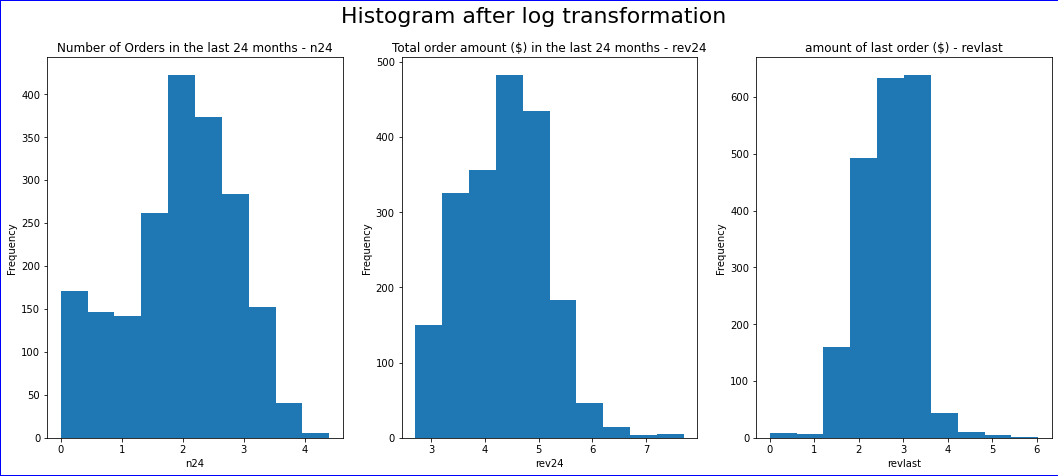

In [8]:
# histogram after log transformation

fig, plots = plt.subplots(1,3,figsize=(18,7))

fig.suptitle("Histogram after log transformation", fontsize = 22)
fig.patch.set_edgecolor('blue')
fig.patch.set_linewidth(2) 

plots[0].set_title("Number of Orders in the last 24 months - n24")
plots[0].set_xlabel("n24")
plots[0].set_ylabel("Frequency")
plots[0].hist(train['log_n24'])

plots[1].set_title("Total order amount ($) in the last 24 months - rev24")
plots[1].set_xlabel("rev24")
plots[1].set_ylabel("Frequency")
plots[1].hist(train['log_rev24'])

plots[2].set_title("amount of last order ($) - revlast")
plots[2].set_xlabel("revlast")
plots[2].set_ylabel("Frequency")
plots[2].hist(train['log_revlast'])

In [9]:
# dropping variables from the dataframe

train = train.drop(columns = ['id', 'n24', 'rev24', 'revlast'])
train

,elpsdm,ordfreq,ordcat,response,log_n24,log_rev24,log_revlast
0,24,1,6,1,0.693147,3.401197,3.044522
1,24,1,6,0,3.218876,5.332719,3.044522
2,24,1,6,0,1.609438,3.951244,2.772589
3,24,1,6,0,2.397895,4.653960,2.772589
4,24,1,6,0,0.693147,3.465736,2.890372
...,...,...,...,...,...,...,...
1995,1,2,6,0,2.484907,4.653960,3.044522
1996,1,2,6,0,3.583519,6.666957,1.791759
1997,1,1,7,0,1.945910,6.028279,4.615121
1998,1,1,7,0,1.609438,4.343805,3.258097


I applied log transformation to transform the skewed variables n24, rev24, and revlast.

    For n24 and rev24, we used log(X) transformation.
    For revlast, we used log(x+1) transformation

## Question 2: Generate a decision tree on the entire dataset, without any limitations on the depth of the tree. Use entropy as the metric. What is the depth of the tree that is generated? Provide a plot of the tree.

In [10]:
# creating X and y sets

y_train = train['response'].to_numpy()
X_train = train.drop('response', axis = 1)
X_train, y_train

(      elpsdm  ordfreq  ordcat   log_n24  log_rev24  log_revlast
 0         24        1       6  0.693147   3.401197     3.044522
 1         24        1       6  3.218876   5.332719     3.044522
 2         24        1       6  1.609438   3.951244     2.772589
 3         24        1       6  2.397895   4.653960     2.772589
 4         24        1       6  0.693147   3.465736     2.890372
 ...      ...      ...     ...       ...        ...          ...
 1995       1        2       6  2.484907   4.653960     3.044522
 1996       1        2       6  3.583519   6.666957     1.791759
 1997       1        1       7  1.945910   6.028279     4.615121
 1998       1        1       7  1.609438   4.343805     3.258097
 1999       1        1       6  3.526361   6.150603     3.465736
 
 [2000 rows x 6 columns],
 array([1, 0, 0, ..., 0, 0, 0], dtype=int64))

In [11]:
# Generating a decision tree

dtree=DecisionTreeClassifier(criterion = 'entropy')
dtree.fit(X_train,y_train)
print('Decision Tree Classifier Created')

Decision Tree Classifier Created


In [12]:
# Depth of the tree

tree_depth = dtree.get_depth()

print("Tree depth:", tree_depth )

Tree depth: 26


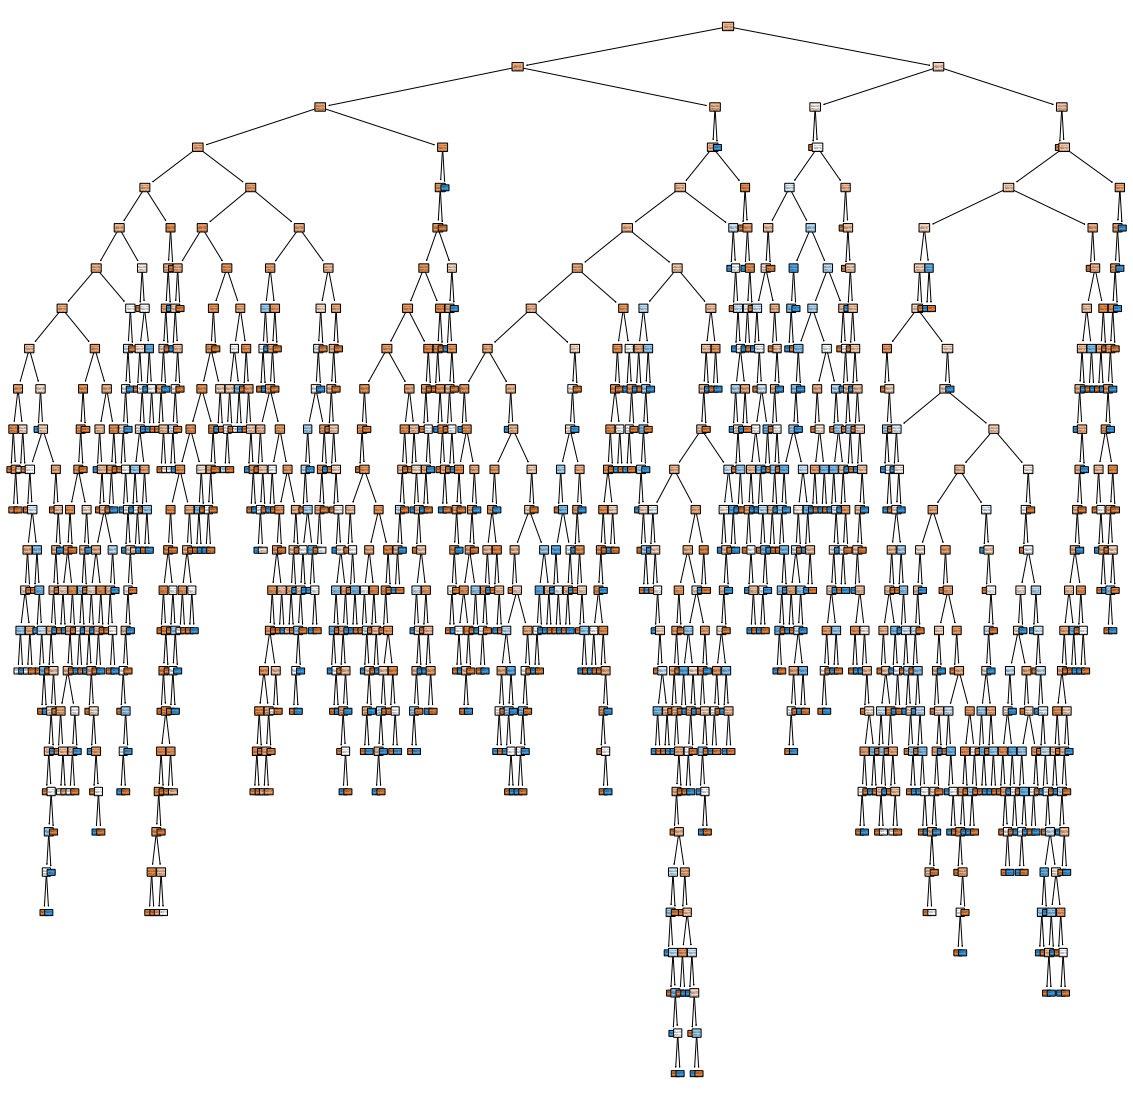

In [13]:
# Print of the tree

plt.figure(figsize = (20,20))
dec_tree = plot_tree(decision_tree=dtree, class_names = ['0', '1'],
                     filled = True , rounded = True)

## Question 3: We will focus on decision trees first, and try to identify the best decision tree classifier by pruning the tree at different depths. Use 10-fold cross validation and identify the best tree depth (again, using accuracy as the metric), by trying as many possible depths as you deem necessary. Provide your reasoning for using the values of tree-depth that you tried. Based on your results, what depth do you recommend? What is the accuracy associated with this tree depth? If you had to select the three best values of tree-depth, what would they be?

In [14]:
# Pruning the decision tree

different_depth_range = range(2, 21)

best_depth = None
best_accuracy = 0

depths_dict = {}

for depth in different_depth_range:
    clf = DecisionTreeClassifier(max_depth = depth)
    
    cv = model_selection.StratifiedKFold(n_splits=10)
    accuracy_score = cross_val_score(clf, X_train, y_train, cv = cv, scoring = 'accuracy')
    mean_accuracy = np.mean(accuracy_score)
    
    depths_dict[depth] = mean_accuracy
    
    if mean_accuracy > best_accuracy:
        best_depth = depth
        best_accuracy = mean_accuracy

print("Tree Depths and Accuracy")
print(" ")
for depth, accuracy in depths_dict.items():
    print(f"Depth {depth}: Accuracy {accuracy:.4f}")

print(" ")
print("Best depth: ", best_depth)
print("Best Accuracy: ", best_accuracy)

Tree Depths and Accuracy
 
Depth 2: Accuracy 0.7075
Depth 3: Accuracy 0.6970
Depth 4: Accuracy 0.6925
Depth 5: Accuracy 0.6755
Depth 6: Accuracy 0.6085
Depth 7: Accuracy 0.5995
Depth 8: Accuracy 0.6190
Depth 9: Accuracy 0.5890
Depth 10: Accuracy 0.5975
Depth 11: Accuracy 0.5715
Depth 12: Accuracy 0.5850
Depth 13: Accuracy 0.5730
Depth 14: Accuracy 0.5635
Depth 15: Accuracy 0.5575
Depth 16: Accuracy 0.5570
Depth 17: Accuracy 0.5325
Depth 18: Accuracy 0.5450
Depth 19: Accuracy 0.5520
Depth 20: Accuracy 0.5495
 
Best depth:  2
Best Accuracy:  0.7074999999999999


**Reasoning for using the values of tree-depth:** 
    My strategy was to select the range of depths from 1 to 15 and observe the accuracy for each depth. 

    Depth recommended: Depth 2
    Accuracy of Depth 2 : 0.7075

**Three best values of tree-depth:** Depth 2, Depth 3, Depth 4

## Question 4: Next, we will consider random forests. Develop a random forest classifier with 100 trees, using the three best values of tree-depth you identified in the previous question. Provide all relevant results. Which tree-depth results in the best random forest classifier? How does it perform relative to the best decision tree?

In [15]:
# Random Forest with 100 trees

# depths selected in previous questions
depths_selected = [2, 3, 4]

# Creating a list to store random forest models
random_forest_models = []

# Creating a dictionary to store the accuracy of tree_depths
depths_dict ={}

best_accuracy = 0
best_depth = None

# Train a random forest model for each depth
for depth in depths_selected:
    rf = RandomForestClassifier(n_estimators = 100, max_depth = depth, random_state = 1, criterion = 'entropy')
    rf.fit(X_train, y_train)
    
    random_forest_models.append(rf)
    
    accuracy_score = cross_val_score(rf, X_train, y_train, cv = cv, scoring = 'accuracy')
    mean_accuracy = np.mean(accuracy_score)
    
    depths_dict[depth] = mean_accuracy
    
    if mean_accuracy > best_accuracy:
        best_depth = depth
        best_accuracy = mean_accuracy

    
for models in random_forest_models:
    print(models)
    
print(" ")        
for depth, accuracy in depths_dict.items():
    print(f"Depth {depth}: Accuracy {accuracy:.4f}")

print(" ")
print("Best depth", best_depth)
print("Best Accuracy", best_accuracy)

RandomForestClassifier(criterion='entropy', max_depth=2, random_state=1)
RandomForestClassifier(criterion='entropy', max_depth=3, random_state=1)
RandomForestClassifier(criterion='entropy', max_depth=4, random_state=1)
 
Depth 2: Accuracy 0.7080
Depth 3: Accuracy 0.7065
Depth 4: Accuracy 0.7060
 
Best depth 2
Best Accuracy 0.708


### It appears that the Random Forest models with a depth of 2 performs slightly better than the model with depths 3 and 4 in terms of accuracy. However, the differences in accuracy between these models are relatively small.

## Question 5: Repeat this experiment with 50 trees. Provide all relevant results. Does your recommendation change?


In [16]:
# Repeating the experiment with 50 trees
# Random Forest

# depths selected in previous questions
depths_selected = [2, 3, 4]

# Creating a list to store random forest models
random_forest_models = []

# Creating a dictionary to store the accuracy of tree_depths
depths_dict ={}

best_accuracy = 0
best_depth = None

# Train a random forest model for each depth
for depth in depths_selected:
    rf = RandomForestClassifier(n_estimators = 50, max_depth = depth, random_state = 1, criterion = 'entropy')
    rf.fit(X_train, y_train)
    
    random_forest_models.append(rf)
    
    accuracy_score = cross_val_score(rf, X_train, y_train, cv = cv, scoring = 'accuracy')
    mean_accuracy = np.mean(accuracy_score)
    
    depths_dict[depth] = mean_accuracy
    
    if mean_accuracy > best_accuracy:
        best_depth = depth
        best_accuracy = mean_accuracy

    
for models in random_forest_models:
    print(models)
    
        
for depth, accuracy in depths_dict.items():
    print(f"Depth {depth}: Accuracy {accuracy:.4f}")

print(" ")
print("Best depth", best_depth)
print("Best Accuracy", best_accuracy)

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=50,
                       random_state=1)
RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=50,
                       random_state=1)
RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=50,
                       random_state=1)
Depth 2: Accuracy 0.7080
Depth 3: Accuracy 0.7050
Depth 4: Accuracy 0.7075
 
Best depth 2
Best Accuracy 0.708


##### Random forest with 50 trees, provides same accuracy for depth 2, compared to random forest with 100 trees.  Accuracy of Depth 2 > Depth 4 > Depth 3

## Question 6: We will now consider k-nearest neighbor models. Use 10-fold cross validation and identify the best value of k, by trying as many values of k as necessary. Keep in mind that very large values of k can affect speed, and that 5 is the default – try at least values from 5 to 10 (you can try more if you wish). Provide all relevant results. What value of k do you recommend? What is the accuracy associated with this value of k? If you had to select the three best values of k, what would they be?

In [17]:
# K-Nearest Neighbor

k_values = range(5,21)

k_accuracy_scores = []

best_k = None
best_accuracy = 0

# Creating a dictionary to store the accuracy of k's
k_dict ={}


for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    
    ##cv = KFold(n_splits = 10, shuffle = True, random_state = 1)
    kf = model_selection.StratifiedKFold(n_splits=10)
    accuracy_score = cross_val_score(knn, X_train, y_train, cv = kf, scoring = 'accuracy')
    mean_accuracy = np.mean(accuracy_score)
    
    k_dict[k] = mean_accuracy
    
    if(mean_accuracy > best_accuracy):
        best_k = k
        best_accuracy = mean_accuracy
    
for k, accuracy in k_dict.items():
    print(f"K {k}: Accuracy {accuracy:.4f}")
print(" ")
print(f"Best K based on Accuracy: {best_k} (Accuracy: {best_accuracy:.4f})")

# Sort the k_dict by accuracy and print the three best k values
sorted_k_dict = dict(sorted(k_dict.items(), key=lambda item: item[1], reverse=True))
top_k_values = list(sorted_k_dict.keys())[:3]
print(" ")
print(f"Top 3 K Values based on Accuracy: {top_k_values}")

K 5: Accuracy 0.5540
K 6: Accuracy 0.6075
K 7: Accuracy 0.5595
K 8: Accuracy 0.6010
K 9: Accuracy 0.5745
K 10: Accuracy 0.6180
K 11: Accuracy 0.5890
K 12: Accuracy 0.6240
K 13: Accuracy 0.5930
K 14: Accuracy 0.6280
K 15: Accuracy 0.6035
K 16: Accuracy 0.6355
K 17: Accuracy 0.6160
K 18: Accuracy 0.6400
K 19: Accuracy 0.6230
K 20: Accuracy 0.6435
 
Best K based on Accuracy: 20 (Accuracy: 0.6435)
 
Top 3 K Values based on Accuracy: [20, 18, 16]


##### KNN with k value of 20, provides better accuracy of 0.6435.

    Recommended K value - 20
    Accuracy associated with best k - 0.6435
    Three best k-value - 20, 18, 16

## Question 7:  Develop a logistic regression model using 10-fold cross validation. What is the associated accuracy?

In [18]:
# Logistic Regression with 10-cross folds

logreg = LogisticRegression()
    
cv = model_selection.StratifiedKFold(n_splits=10)
accuracy_score = cross_val_score(logreg, X_train, y_train, cv = cv, scoring = 'accuracy')
mean_accuracy = np.mean(accuracy_score)
        
print(f"Associated Accuracy: {mean_accuracy:.4f}")

Associated Accuracy: 0.7110


## Question 8: Develop a logistic regression model on the entire training dataset. Provide the output. 


In [19]:
X = sm.add_constant(X_train)
X

,const,elpsdm,ordfreq,ordcat,log_n24,log_rev24,log_revlast
0,1.0,24,1,6,0.693147,3.401197,3.044522
1,1.0,24,1,6,3.218876,5.332719,3.044522
2,1.0,24,1,6,1.609438,3.951244,2.772589
3,1.0,24,1,6,2.397895,4.653960,2.772589
4,1.0,24,1,6,0.693147,3.465736,2.890372
...,...,...,...,...,...,...,...
1995,1.0,1,2,6,2.484907,4.653960,3.044522
1996,1.0,1,2,6,3.583519,6.666957,1.791759
1997,1.0,1,1,7,1.945910,6.028279,4.615121
1998,1.0,1,1,7,1.609438,4.343805,3.258097


In [20]:
# Logistic Regression on Entire dataset

logreg1 = sm.Logit(y_train, X).fit()
print(logreg1.summary())

Optimization terminated successfully.
         Current function value: 0.584003
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1993
Method:                           MLE   Df Model:                            6
Date:                Sun, 08 Oct 2023   Pseudo R-squ.:                 0.03300
Time:                        19:49:02   Log-Likelihood:                -1168.0
converged:                       True   LL-Null:                       -1207.9
Covariance Type:            nonrobust   LLR p-value:                 4.080e-15
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5752      0.592      0.972      0.331      -0.585       1.735
elpsdm         -0.0339    

In [21]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

coefficient = logreg.coef_
intercept = logreg.intercept_

print("Logistic Regression Coefficients:")
for i, coef in enumerate(coefficient[0]):
    print(f"Feature {i+1}: {coef:.4f}")

print(f"Intercept: {intercept[0]:.4f}")
print(" ")
print("Training Score: ",logreg.score(X_train, y_train))

Logistic Regression Coefficients:
Feature 1: -0.0339
Feature 2: 0.1738
Feature 3: -0.1246
Feature 4: 0.1106
Feature 5: -0.1020
Feature 6: -0.1458
Intercept: 0.5733
 
Training Score:  0.7145


In [22]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## Question 9: Using the four best models identified in each category (decision tree, random forest, k-nearest neighbor, logistic regression), perform an evaluation with 10-fold cross-validation. Your results should be similar (but not necessarily identical) to the results you have already obtained for these models. Across these four models, which one would you recommend, and why?

In [23]:
# Model comparison

modelsFinal=[]
modelsFinal.append(('DT2', DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)))
modelsFinal.append(('RF2', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 2)))
modelsFinal.append(('RF2', RandomForestClassifier(n_estimators = 50, criterion = 'entropy', max_depth = 2)))
modelsFinal.append(('KNN20', KNeighborsClassifier(n_neighbors=20)))
modelsFinal.append(('LR', LogisticRegression()))

In [24]:
metric = 'accuracy'
resultsA = []
mIDsA = []
for mID, mdl in modelsFinal:
    kf = model_selection.StratifiedKFold(n_splits=10)
    cvres = model_selection.cross_val_score(mdl, X_train, y_train, cv=kf, scoring=metric)
    resultsA.append(cvres)
    mIDsA.append(mID)
    print("%s: %3f (%3f)" % (mID, cvres.mean(), cvres.std()))

DT2: 0.707000 (0.003317)
RF2: 0.708000 (0.002449)
RF2: 0.707500 (0.003354)
KNN20: 0.643500 (0.052728)
LR: 0.711000 (0.006633)


## Question 10: Use the entire dataset to develop a final version of the recommended model for testing. Provide all details of the model (and the tree if the recommended model is the decision tree). What is that accuracy of this model on the training dataset?

In [25]:
logreg = LogisticRegression(random_state=1)

logreg.fit(X_train, y_train)

coefficient = logreg.coef_
intercept = logreg.intercept_

print("Logistic Regression Coefficients:")
for i, coef in enumerate(coefficient[0]):
    print(f"Feature {i+1}: {coef:.4f}")

print(f"Intercept: {intercept[0]:.4f}")
print(" ")
print("Training Score: ",logreg.score(X_train, y_train))

Logistic Regression Coefficients:
Feature 1: -0.0339
Feature 2: 0.1738
Feature 3: -0.1246
Feature 4: 0.1106
Feature 5: -0.1020
Feature 6: -0.1458
Intercept: 0.5733
 
Training Score:  0.7145


In [26]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## Question 11: Read the file dmtest.csv and make predictions (using the final model) on which customers are likely to respond, and which are not. The predictions have to be 0 or 1 – if the model you selected naturally gives a probability score, use 0.5 as the threshold to determine whether your prediction will be 0 or 1. For example, if you use a logistic regression model that gives you a probability estimate of 0.51, the prediction should be 1, and if it gives a probability estimate of 0.49, the prediction should be 0.


In [27]:
X_test = pd.read_csv('dmtest.csv')
X_test

,id,n24,rev24,revlast,elpsdm,ordfreq,ordcat
0,5001,5,186.0,18,24,1,6
1,5002,2,30.0,15,24,1,6
2,5003,24,362.0,30,24,1,7
3,5004,4,41.0,15,24,1,6
4,5005,5,59.0,18,24,1,6
...,...,...,...,...,...,...,...
1995,6996,9,165.0,0,1,1,7
1996,6997,11,149.0,15,1,3,6
1997,6998,18,161.0,13,1,2,5
1998,6999,26,427.0,25,1,4,7


In [28]:
# Log transforming skewed variables

X_test['log_n24'] = np.log(X_test['n24'])
X_test['log_rev24'] = np.log(X_test['rev24'])
X_test['log_revlast'] = np.log(X_test['revlast']+1)
X_test

# dropping variables from the dataframe
X_test = X_test.drop(columns = ['id', 'n24', 'rev24', 'revlast'])
X_test

,elpsdm,ordfreq,ordcat,log_n24,log_rev24,log_revlast
0,24,1,6,1.609438,5.225747,2.944439
1,24,1,6,0.693147,3.401197,2.772589
2,24,1,7,3.178054,5.891644,3.433987
3,24,1,6,1.386294,3.713572,2.772589
4,24,1,6,1.609438,4.077537,2.944439
...,...,...,...,...,...,...
1995,1,1,7,2.197225,5.105945,0.000000
1996,1,3,6,2.397895,5.003946,2.772589
1997,1,2,5,2.890372,5.081404,2.639057
1998,1,4,7,3.258097,6.056784,3.258097


In [29]:
# Prediction Probability
prob = logreg.predict_proba(X_test)
res_arr = []
for i in prob:
    if i[1] >= 0.5:
        res_arr.append(1)
    else:
        res_arr.append(0)

In [30]:
X_test['prediction'] = res_arr
X_test
X_test.to_csv("group04dmtest.csv", encoding='utf-8', index=False)
group04dmtest=pd.read_csv('group04dmtest.csv')
group04dmtest.head()

,elpsdm,ordfreq,ordcat,log_n24,log_rev24,log_revlast,prediction
0,24,1,6,1.609438,5.225747,2.944439,0
1,24,1,6,0.693147,3.401197,2.772589,0
2,24,1,7,3.178054,5.891644,3.433987,0
3,24,1,6,1.386294,3.713572,2.772589,0
4,24,1,6,1.609438,4.077537,2.944439,0


## Question 12: If you were to focus on the “lapsing customers” (customers who made their last purchase 13 to 24 months ago), do you expect your model to be different? For the selected model, compare the quality of predictions for these customers relative to predictions for the others on records in the training set. 

In [31]:
train

,elpsdm,ordfreq,ordcat,response,log_n24,log_rev24,log_revlast
0,24,1,6,1,0.693147,3.401197,3.044522
1,24,1,6,0,3.218876,5.332719,3.044522
2,24,1,6,0,1.609438,3.951244,2.772589
3,24,1,6,0,2.397895,4.653960,2.772589
4,24,1,6,0,0.693147,3.465736,2.890372
...,...,...,...,...,...,...,...
1995,1,2,6,0,2.484907,4.653960,3.044522
1996,1,2,6,0,3.583519,6.666957,1.791759
1997,1,1,7,0,1.945910,6.028279,4.615121
1998,1,1,7,0,1.609438,4.343805,3.258097


In [32]:
# Prediction on Training dataset
train_lap = train[(train['elpsdm'] >= 13) & (train['elpsdm'] <= 24)]

train_lap

,elpsdm,ordfreq,ordcat,response,log_n24,log_rev24,log_revlast
0,24,1,6,1,0.693147,3.401197,3.044522
1,24,1,6,0,3.218876,5.332719,3.044522
2,24,1,6,0,1.609438,3.951244,2.772589
3,24,1,6,0,2.397895,4.653960,2.772589
4,24,1,6,0,0.693147,3.465736,2.890372
...,...,...,...,...,...,...,...
1648,13,1,7,0,1.386294,4.744932,3.583519
1649,13,4,5,0,3.367296,5.117994,1.791759
1650,13,4,4,0,2.564949,3.713572,1.386294
1651,13,4,7,0,1.945910,5.424950,3.713572


In [33]:
y_train_lap = train_lap['response'].to_numpy()
X_train_lap = train_lap.drop('response', axis = 1)
X_train_lap, y_train_lap

(      elpsdm  ordfreq  ordcat   log_n24  log_rev24  log_revlast
 0         24        1       6  0.693147   3.401197     3.044522
 1         24        1       6  3.218876   5.332719     3.044522
 2         24        1       6  1.609438   3.951244     2.772589
 3         24        1       6  2.397895   4.653960     2.772589
 4         24        1       6  0.693147   3.465736     2.890372
 ...      ...      ...     ...       ...        ...          ...
 1648      13        1       7  1.386294   4.744932     3.583519
 1649      13        4       5  3.367296   5.117994     1.791759
 1650      13        4       4  2.564949   3.713572     1.386294
 1651      13        4       7  1.945910   5.424950     3.713572
 1652      13        4       6  2.833213   5.525453     3.044522
 
 [1653 rows x 6 columns],
 array([1, 0, 0, ..., 0, 0, 0], dtype=int64))

In [34]:
LR = LogisticRegression().fit(X_train_lap, y_train_lap)
LR.score(X_train_lap, y_train_lap)

0.7265577737447066